# TimeQuant Quickstart

Demo of a streaming **Gaussian-Quantile tokenizer** for continuous time series.
- Univariate online tokenization with running mean/variance (Welford).
- Simple multivariate extension (per-dimension binning + k-means codebook).

> This notebook is standalone and dependency-light (NumPy & Matplotlib).

In [ ]:

import math
import numpy as np
import matplotlib.pyplot as plt

# Utility: numerically stable running stats (Welford)
class RunningStats:
    def __init__(self, dim=None, eps=1e-8):
        self.n = 0
        self.mean = None if dim is None else np.zeros(dim, dtype=float)
        self.M2 = None if dim is None else np.zeros(dim, dtype=float)
        self.eps = eps
    def update(self, x):
        x = np.asarray(x)
        if self.mean is None:
            self.mean = np.zeros_like(x, dtype=float)
            self.M2 = np.zeros_like(x, dtype=float)
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
    @property
    def var(self):
        if self.n < 2:
            return np.zeros_like(self.mean)
        return self.M2 / (self.n - 1)
    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

# Fast approximation to the inverse CDF (PPF) of N(0,1) using Acklam's method
# Source: https://web.archive.org/web/20151030230722/http://home.online.no/~pjacklam/notes/invnorm/
def norm_ppf(p):
    if p <= 0.0 or p >= 1.0:
        if p == 0.0: return -np.inf
        if p == 1.0: return np.inf
        raise ValueError("p must be in (0,1)")
    # Coefficients in rational approximations
    a = [-3.969683028665376e+01,  2.209460984245205e+02,
         -2.759285104469687e+02,  1.383577518672690e+02,
         -3.066479806614716e+01,  2.506628277459239e+00]
    b = [-5.447609879822406e+01,  1.615858368580409e+02,
         -1.556989798598866e+02,  6.680131188771972e+01,
         -1.328068155288572e+01]
    c = [-7.784894002430293e-03, -3.223964580411365e-01,
         -2.400758277161838e+00, -2.549732539343734e+00,
          4.374664141464968e+00,  2.938163982698783e+00]
    d = [ 7.784695709041462e-03,  3.224671290700398e-01,
          2.445134137142996e+00,  3.754408661907416e+00]
    # Define break-points
    plow  = 0.02425
    phigh = 1 - plow
    if p < plow:
        q = math.sqrt(-2*math.log(p))
        return (((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5]) /                ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
    if phigh < p:
        q = math.sqrt(-2*math.log(1-p))
        return -(((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5]) /                  ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
    q = p - 0.5
    r = q*q
    return (((((a[0]*r + a[1])*r + a[2])*r + a[3])*r + a[4])*r + a[5])*q /            (((((b[0]*r + b[1])*r + b[2])*r + b[3])*r + b[4])*r + 1)

class QuantileBinner:
    def __init__(self, V):
        self.V = int(V)
        qs = np.linspace(0, 1, self.V + 1)[1:-1]
        self.boundaries = np.array([norm_ppf(float(q)) for q in qs], dtype=float)
    def encode_scalar(self, z):
        # (-inf, b0], (b0, b1], ..., (b_{V-2}, inf)
        # use binary search via numpy
        return int(np.searchsorted(self.boundaries, z, side="right"))
    def decode_scalar(self, tok):
        if tok == 0:
            lo, hi = -np.inf, self.boundaries[0]
        elif tok == self.V - 1:
            lo, hi = self.boundaries[-1], np.inf
        else:
            lo, hi = self.boundaries[tok-1], self.boundaries[tok]
        # midpoint via CDF mid-quantile
        def norm_cdf(x):  # numerical stable erf-based CDF
            return 0.5 * (1 + math.erf(x / math.sqrt(2)))
        q_lo = 0.0 if math.isinf(lo) and lo < 0 else norm_cdf(lo)
        q_hi = 1.0 if math.isinf(hi) and hi > 0 else norm_cdf(hi)
        q_mid = 0.5 * (q_lo + q_hi)
        return norm_ppf(q_mid)

class GQTokenizer:
    def __init__(self, V, eps=1e-8, multivariate=False, V_total=None):
        """
        Gaussian-Quantile Tokenizer for both univariate and multivariate time series.
        
        Args:
            V: Vocabulary size per dimension (for univariate) or per dimension (for multivariate)
            eps: Numerical stability parameter
            multivariate: If True, handles multivariate data with k-means clustering
            V_total: Total vocabulary size for multivariate case (if None, uses V^D)
        """
        self.V = V
        self.eps = eps
        self.multivariate = multivariate
        
        if multivariate:
            # For multivariate case, we'll use per-dimension tokenizers + k-means
            self.dim_tokenizers = None  # Will be initialized when we know the dimension
            self.centroids = None
            self.V_total = V_total
            self.fitted = False
        else:
            # For univariate case, use the original approach
            self.stats = RunningStats()
            self.binner = QuantileBinner(V)
    
    def update(self, x):
        """Update the tokenizer with new data point(s)."""
        x = np.asarray(x)
        
        if self.multivariate:
            if x.ndim == 1:
                x = x.reshape(1, -1)  # Ensure 2D for multivariate case
            
            if self.dim_tokenizers is None:
                # Initialize per-dimension tokenizers
                D = x.shape[1]
                self.dim_tokenizers = [GQTokenizer(self.V, self.eps, multivariate=False) for _ in range(D)]
                if self.V_total is None:
                    self.V_total = self.V ** D
            
            # Update each dimension's tokenizer
            for d in range(x.shape[1]):
                self.dim_tokenizers[d].update(x[:, d])
        else:
            # Univariate case
            if x.ndim > 1:
                raise ValueError("For univariate tokenizer, input must be scalar or 1D")
            self.stats.update(x)
    
    def encode(self, x):
        """Encode data point(s) to token(s)."""
        x = np.asarray(x)
        
        if self.multivariate:
            if not self.fitted:
                raise ValueError("Multivariate tokenizer must be fitted with k-means before encoding")
            
            if x.ndim == 1:
                x = x.reshape(1, -1)
            
            # Get per-dimension codes
            codes = np.empty((x.shape[0], len(self.dim_tokenizers)), dtype=int)
            for i in range(x.shape[0]):
                for d in range(len(self.dim_tokenizers)):
                    codes[i, d] = self.dim_tokenizers[d].encode(x[i, d])
            
            # Find nearest centroid for each code vector
            if x.shape[0] == 1:
                d2 = ((codes[0, None, :] - self.centroids[None, :, :])**2).sum(-1)
                return d2.argmin()
            else:
                d2 = ((codes[:, None, :] - self.centroids[None, :, :])**2).sum(-1)
                return d2.argmin(axis=1)
        else:
            # Univariate case
            if x.ndim > 1:
                raise ValueError("For univariate tokenizer, input must be scalar or 1D")
            z = (x - self.stats.mean) / self.stats.std
            return self.binner.encode_scalar(float(z))
    
    def decode(self, tok):
        """Decode token(s) back to data point(s)."""
        if self.multivariate:
            if not self.fitted:
                raise ValueError("Multivariate tokenizer must be fitted with k-means before decoding")
            
            tok = np.asarray(tok)
            if tok.ndim == 0:
                # Single token
                return self.centroids[tok].copy()
            else:
                # Multiple tokens
                return self.centroids[tok].copy()
        else:
            # Univariate case
            z = self.binner.decode_scalar(tok)
            return float(self.stats.mean + z * self.stats.std)
    
    def fit_kmeans(self, X, iters=50, seed=0):
        """Fit k-means clustering on the per-dimension codes (multivariate case only)."""
        if not self.multivariate:
            raise ValueError("fit_kmeans only applies to multivariate tokenizers")
        
        if self.dim_tokenizers is None:
            raise ValueError("Must call update() on some data before fitting k-means")
        
        # Generate codes for all data points
        codes = np.empty((X.shape[0], len(self.dim_tokenizers)), dtype=int)
        for i in range(X.shape[0]):
            for d in range(len(self.dim_tokenizers)):
                codes[i, d] = self.dim_tokenizers[d].encode(X[i, d])
        
        # Fit k-means on the codes
        self.centroids = self._kmeans_numpy(codes.astype(float), k=self.V_total, iters=iters, seed=seed)
        self.fitted = True
        
        return self.centroids
    
    def _kmeans_numpy(self, X, k, iters=50, seed=0):
        """Internal k-means implementation."""
        rng = np.random.default_rng(seed)
        idx = rng.choice(len(X), size=k, replace=False)
        C = X[idx].astype(float).copy()
        for _ in range(iters):
            # assign
            d2 = ((X[:, None, :] - C[None, :, :])**2).sum(-1)
            y = d2.argmin(axis=1)
            # update
            for j in range(k):
                mask = (y == j)
                if mask.any():
                    C[j] = X[mask].mean(axis=0)
        return C


## 1) Univariate streaming demo

First 20 tokens: [ 8 12 13 14 14 12 13 13 12 13 12 14 14 14 14 14 15 14 14 13]


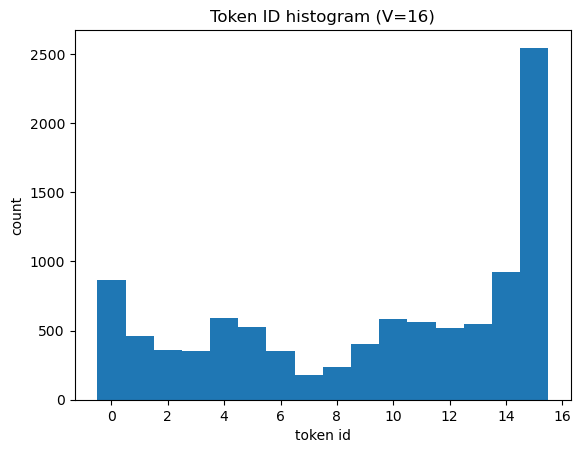

In [2]:

np.random.seed(0)
T = 10_000
# generate a nonstationary series: random walk + drift + noise
x = np.cumsum(np.random.randn(T) * 0.5) + 0.01*np.arange(T) + 0.5*np.sin(np.arange(T)/50)

tok = GQTokenizer(V=16)
tokens = np.empty(T, dtype=int)
for t in range(T):
    tok.update(x[t])
    tokens[t] = tok.encode(x[t])

print("First 20 tokens:", tokens[:20])
# Plot token histogram
plt.figure()
bins = np.arange(17)-0.5
plt.hist(tokens, bins=bins)
plt.title("Token ID histogram (V=16)")
plt.xlabel("token id"); plt.ylabel("count")
plt.show()


## 2) Multivariate per-dimension binning + simple k-means codebook

/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_3989/2917892678.py:166: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self.binner.encode_scalar(float(z))


Unique tokens used: 8/8; perplexity≈5.78


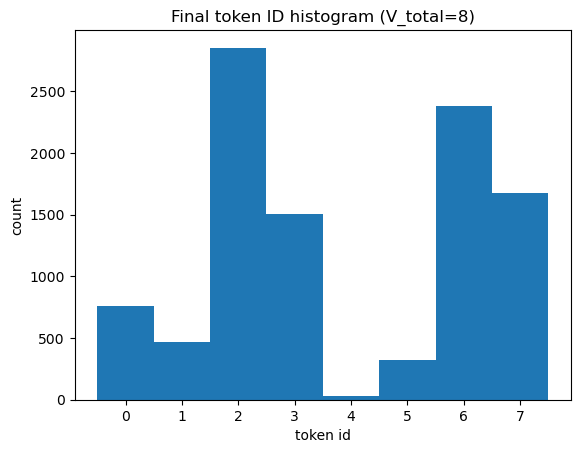


Testing decode functionality:
Original X[0]: [-0.0202117  -0.0787855   0.14702435  0.09622707]
Decoded X[0]: [0. 0. 1. 0.]
Reconstruction error: 0.8622


In [3]:

D = 4
V_dim = 2  # 1-bit per dim
V_total = 8  # final vocab via codebook

# make a 4D series with correlations
cov = np.array([[1.0, 0.6, 0.0, 0.1],
                [0.6, 1.0, 0.2, 0.0],
                [0.0, 0.2, 1.0, 0.4],
                [0.1, 0.0, 0.4, 1.0]])
L = np.linalg.cholesky(cov)
z = np.random.randn(T, D) @ L.T
X = (np.cumsum(z, axis=0) * 0.1) + 0.1*np.sin(np.arange(T)[:,None]/30)

# Create multivariate tokenizer
multivariate_tok = GQTokenizer(V=V_dim, multivariate=True, V_total=V_total)

# Update tokenizer with all data (streaming approach)
for t in range(T):
    multivariate_tok.update(X[t])

# Fit k-means on a subset (streaming-friendly would use minibatches)
subset = X[1000:6000]
centroids = multivariate_tok.fit_kmeans(subset, iters=40, seed=0)

# Now encode all data using the fitted tokenizer
final_tokens = np.empty(T, dtype=int)
for t in range(T):
    final_tokens[t] = multivariate_tok.encode(X[t])

# utilization & perplexity
vals, counts = np.unique(final_tokens, return_counts=True)
p = counts / counts.sum()
H = -(p * np.log(p + 1e-12)).sum()
perplexity = float(np.exp(H))
print(f"Unique tokens used: {len(vals)}/{V_total}; perplexity≈{perplexity:.2f}")

plt.figure()
bins = np.arange(V_total+1)-0.5
plt.hist(final_tokens, bins=bins)
plt.title("Final token ID histogram (V_total=%d)" % V_total)
plt.xlabel("token id"); plt.ylabel("count")
plt.show()

# Test decoding
print(f"\nTesting decode functionality:")
print(f"Original X[0]: {X[0]}")
decoded = multivariate_tok.decode(final_tokens[0])
print(f"Decoded X[0]: {decoded}")
print(f"Reconstruction error: {np.linalg.norm(X[0] - decoded):.4f}")


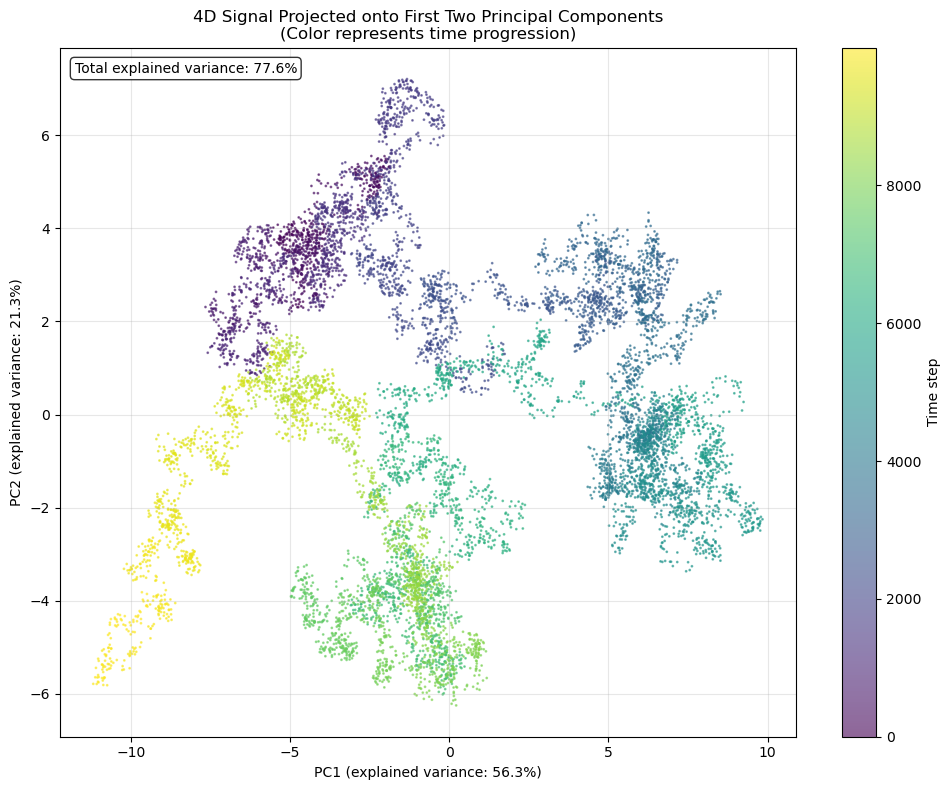

PCA explained variance ratios: [0.56311099 0.21333942]
Total explained variance by first 2 PCs: 77.6%


In [ ]:
# Visualize 4D signal via PCA projection with time-based coloring
from sklearn.decomposition import PCA

# Compute PCA on the 4D signal
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create the visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(T), 
                     cmap='viridis', alpha=0.6, s=1)

plt.colorbar(scatter, label='Time step')
plt.xlabel(f'PC1 (explained variance: {pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 (explained variance: {pca.explained_variance_ratio_[1]:.1%})')
plt.title('4D Signal Projected onto First Two Principal Components\n(Color represents time progression)')
plt.grid(True, alpha=0.3)

# Add some statistics
total_var = pca.explained_variance_ratio_.sum()
plt.text(0.02, 0.98, f'Total explained variance: {total_var:.1%}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")
print(f"Total explained variance by first 2 PCs: {total_var:.1%}")


/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_3989/2917892678.py:166: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self.binner.encode_scalar(float(z))


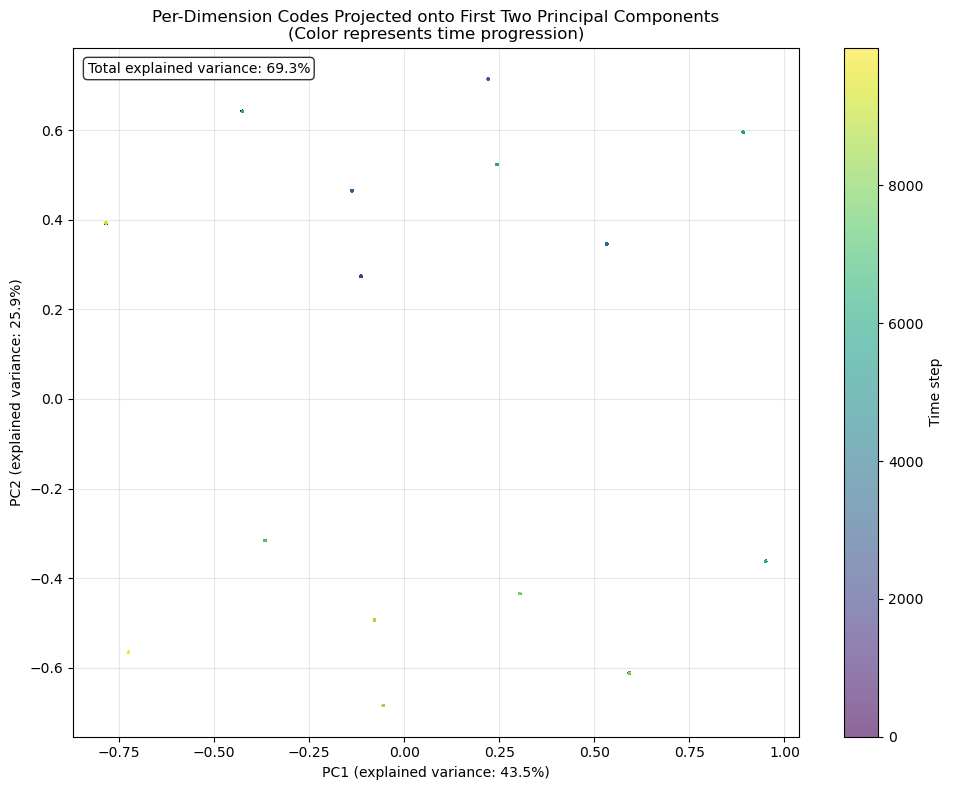

Codes PCA explained variance ratios: [0.43475623 0.2586145 ]
Total explained variance by first 2 PCs: 69.3%

Comparison:
Original signal - Total explained variance: 77.6%
Codes matrix - Total explained variance: 69.3%
Difference: 8.3%


In [ ]:
# Visualize the per-dimension codes via PCA projection with time-based coloring
# This shows how the tokenized representation looks in 2D space

# Get the per-dimension codes from the multivariate tokenizer
codes = np.empty((T, D), dtype=int)
for t in range(T):
    for d in range(D):
        codes[t, d] = multivariate_tok.dim_tokenizers[d].encode(X[t, d])

# Compute PCA on the codes matrix (T x D)
pca_codes = PCA(n_components=2)
codes_pca = pca_codes.fit_transform(codes.astype(float))

# Create the visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(codes_pca[:, 0], codes_pca[:, 1], c=np.arange(T), 
                     cmap='viridis', alpha=0.6, s=1)

plt.colorbar(scatter, label='Time step')
plt.xlabel(f'PC1 (explained variance: {pca_codes.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 (explained variance: {pca_codes.explained_variance_ratio_[1]:.1%})')
plt.title('Per-Dimension Codes Projected onto First Two Principal Components\n(Color represents time progression)')
plt.grid(True, alpha=0.3)

# Add some statistics
total_var_codes = pca_codes.explained_variance_ratio_.sum()
plt.text(0.02, 0.98, f'Total explained variance: {total_var_codes:.1%}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Codes PCA explained variance ratios: {pca_codes.explained_variance_ratio_}")
print(f"Total explained variance by first 2 PCs: {total_var_codes:.1%}")

# Compare with original signal
print(f"\nComparison:")
print(f"Original signal - Total explained variance: {total_var:.1%}")
print(f"Codes matrix - Total explained variance: {total_var_codes:.1%}")
print(f"Difference: {abs(total_var - total_var_codes):.1%}")


In [6]:
# np.unique(codes, axis=0), len(np.unique(codes, axis=0)) # V_dim^D - 1

# np.unique(codes_pca, axis=0).shape # V_dim^D - 1

# centroids # V_total (final vocab size)

# plt.plot(final_tokens)